<a href="https://colab.research.google.com/github/jlonge4/gen_ai_utils/blob/main/csv_graph_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric networkx matplotlib sentence_transformers openai

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from sentence_transformers import SentenceTransformer
import openai  # or your preferred LLM API

# Load CSV
df = pd.read_csv('Accounts.csv')

# Create HeteroData object
data = HeteroData()

# Automatically determine node types (columns) and create nodes
for column in df.columns:
    unique_values = df[column].unique()
    data[column].x = torch.arange(len(unique_values))
    data[column].mapping = {val: idx for idx, val in enumerate(unique_values)}

# Create edges between all columns
for col1 in df.columns:
    for col2 in df.columns:
        if col1 != col2:
            edges = []
            for _, row in df.iterrows():
                src = data[col1].mapping[row[col1]]
                dst = data[col2].mapping[row[col2]]
                edges.append([src, dst])
            data[col1, f'connected_to_{col2}', col2].edge_index = torch.tensor(edges).t().contiguous()

print(data)

In [234]:
df.head()

,CompanyEXTID,Company Name,City,State
0,1,Yadel,Cheyenne,Wyoming
1,2,Camido,Stamford,Connecticut
2,3,Trudeo,Seattle,Washington
3,4,Gigaclub,Anchorage,Alaska
4,5,Brainverse,Troy,Michigan


In [165]:
# Create embeddings for node values
model = SentenceTransformer('all-MiniLM-L6-v2')
for node_type in data.node_types:
    values = list(data[node_type].mapping.keys())
    # Convert all values to strings
    string_values = [str(value) for value in values]
    embeddings = model.encode(string_values)
    data[node_type].embeddings = torch.tensor(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [166]:
def get_graph_summary(data):
    summary = {
        "node_types": list(data.node_types),
        "edge_types": list(data.edge_types),
        "node_counts": {node_type: data[node_type].num_nodes for node_type in data.node_types},
        "edge_counts": {edge_type: data[edge_type].num_edges for edge_type in data.edge_types},
        "node_features": {node_type: list(data[node_type].keys()) for node_type in data.node_types}
    }
    return summary
graph_summary = get_graph_summary(data)
graph_summary

{'node_types': ['CompanyEXTID', 'Company Name', 'City', 'State'],
 'edge_types': [('CompanyEXTID', 'connected_to_Company Name', 'Company Name'),
  ('CompanyEXTID', 'connected_to_City', 'City'),
  ('CompanyEXTID', 'connected_to_State', 'State'),
  ('Company Name', 'connected_to_CompanyEXTID', 'CompanyEXTID'),
  ('Company Name', 'connected_to_City', 'City'),
  ('Company Name', 'connected_to_State', 'State'),
  ('City', 'connected_to_CompanyEXTID', 'CompanyEXTID'),
  ('City', 'connected_to_Company Name', 'Company Name'),
  ('City', 'connected_to_State', 'State'),
  ('State', 'connected_to_CompanyEXTID', 'CompanyEXTID'),
  ('State', 'connected_to_Company Name', 'Company Name'),
  ('State', 'connected_to_City', 'City')],
 'node_counts': {'CompanyEXTID': 100,
  'Company Name': 87,
  'City': 79,
  'State': 36},
 'edge_counts': {('CompanyEXTID',
   'connected_to_Company Name',
   'Company Name'): 100,
  ('CompanyEXTID', 'connected_to_City', 'City'): 100,
  ('CompanyEXTID', 'connected_to_State'

In [188]:
# Function to query the graph using LLM
from openai import OpenAI

def query_graph(data, query):
    # Use LLM to interpret the query and generate PyG operations
    llm_prompt = f"""
    You are given the following graph structure information about an existing graph containing data:
    {data}

    And the user query: "{query}"

    Generate python code using PyTorch Geometric to query the existing graph to answer the user's question.
    Do not use functions, only the lines.
    The code must be only the necessary lines to run the query and print the output.
    Start your output after the import statement 'from torch_geometric.data import HeteroData' and finish the query.
    Use the markdown format for code blocks. Remember that the data is already populated therefore data = HeteroData() does not need to be used.
    """
    key = os.environ.get('OPENAI_API_KEY')

    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": "You are a professional at writing torch geometric code for querying graphs. You must never provide example usage"},
        {"role": "user", "content": llm_prompt}
      ]
    )

    print(response.choices[0].message)


    generated_code = response.choices[0].message.content.strip()

    return generated_code

user_query = "How many companies are in South Carolina?"
generated_code = query_graph(data, user_query)
print(f"Query: {user_query}")
print(f"Result: {generated_code}")

ChatCompletionMessage(content="```python\nfrom torch_geometric.data import HeteroData\n\nstate_index = 10  # South Carolina mapping is 10\ncompany_indices = data['CompanyEXTID', 'connected_to_State', 'State'].edge_index[0][\n    data['CompanyEXTID', 'connected_to_State', 'State'].edge_index[1] == state_index]\nnum_companies = len(company_indices.unique())\nprint(num_companies)\n```", role='assistant', function_call=None, tool_calls=None)
Query: How many companies are in South Carolina?
Result: ```python
from torch_geometric.data import HeteroData

state_index = 10  # South Carolina mapping is 10
company_indices = data['CompanyEXTID', 'connected_to_State', 'State'].edge_index[0][
    data['CompanyEXTID', 'connected_to_State', 'State'].edge_index[1] == state_index]
num_companies = len(company_indices.unique())
print(num_companies)
```


In [189]:
final_code = generated_code.split('```python')[1].split('```')[0]
print(final_code)


from torch_geometric.data import HeteroData

state_index = 10  # South Carolina mapping is 10
company_indices = data['CompanyEXTID', 'connected_to_State', 'State'].edge_index[0][
    data['CompanyEXTID', 'connected_to_State', 'State'].edge_index[1] == state_index]
num_companies = len(company_indices.unique())
print(num_companies)



In [190]:
try:
    result = exec(final_code)
except Exception as e:
    print(f"Error executing query: {str(e)}")

2


#NetworkX Conversion

In [247]:
import networkx as nx
from torch_geometric.utils import to_networkx

def convert_to_networkx(data):
    G = nx.Graph()

    # Add nodes
    for node_type in data.node_types:
        for node, idx in data[node_type].mapping.items():
            G.add_node(f"{node_type}_{idx}", type=node_type, name=node)

    # Add edges
    for edge_type in data.edge_types:
        src_type, _, dst_type = edge_type
        edge_index = data[edge_type].edge_index
        for i in range(edge_index.size(1)):
            src = f"{src_type}_{edge_index[0, i].item()}"
            dst = f"{dst_type}_{edge_index[1, i].item()}"
            G.add_edge(src, dst)

    return G

G = convert_to_networkx(data)

In [195]:
def find_companies_in_state(G, state_name):
    state_node = next((node for node, attr in G.nodes(data=True)
                       if attr['type'] == 'State' and attr['name'] == state_name), None)
    if not state_node:
        return []

    companies = []
    for neighbor in G.neighbors(state_node):
        if G.nodes[neighbor]['type'] == 'CompanyEXTID':
            company_name_node = next((n for n in G.neighbors(neighbor)
                                      if G.nodes[n]['type'] == 'Company Name'), None)
            if company_name_node:
                companies.append(G.nodes[company_name_node]['name'])

    return companies

def find_company_info(G, company_name):
    company_node = next((node for node, attr in G.nodes(data=True)
                         if attr['type'] == 'Company Name' and attr['name'] == company_name), None)
    if not company_node:
        return None

    info = {'name': company_name, 'city': None, 'state': None}
    for neighbor in G.neighbors(company_node):
        neighbor_type = G.nodes[neighbor]['type']
        if neighbor_type == 'City':
            info['city'] = G.nodes[neighbor]['name']
        elif neighbor_type == 'State':
            info['state'] = G.nodes[neighbor]['name']

    return info

def find_companies_in_city(G, city_name):
    city_node = next((node for node, attr in G.nodes(data=True)
                      if attr['type'] == 'City' and attr['name'] == city_name), None)
    if not city_node:
        return []

    companies = []
    for neighbor in G.neighbors(city_node):
        if G.nodes[neighbor]['type'] == 'Company Name':
            companies.append(G.nodes[neighbor]['name'])

    return companies

In [196]:
# Find companies in a state
illinois_companies = find_companies_in_state(G, 'Illinois')
print("Companies in Illinois:", illinois_companies)

# Find information about a specific company
company_info = find_company_info(G, 'Yadel')
print("Yadel info:", company_info)

# Find companies in a city
seattle_companies = find_companies_in_city(G, 'Seattle')
print("Companies in Seattle:", seattle_companies)

Companies in Illinois: ['Aibox', 'Rhycero', 'Realbridge', 'Talane', 'Midel']
Yadel info: {'name': 'Yadel', 'city': 'Cheyenne', 'state': 'Wyoming'}
Companies in Seattle: ['Trudeo', 'Fivespan', 'Realbuzz', 'Ntag']


#Modularize this approach

In [200]:
def get_graph_summary(G):
    summary = {
        "node_types": set(),
        "edge_types": set(),
        "node_attributes": {},
        "node_counts": {},
    }
    for node, data in G.nodes(data=True):
        node_type = data.get('type')
        summary["node_types"].add(node_type)
        summary["node_counts"][node_type] = summary["node_counts"].get(node_type, 0) + 1
        if node_type not in summary["node_attributes"]:
            summary["node_attributes"][node_type] = set(data.keys()) - {'type'}

    for u, v, data in G.edges(data=True):
        summary["edge_types"].add((G.nodes[u]['type'], G.nodes[v]['type']))

    return summary

In [236]:
from pprint import pprint
import os
def query_graph(G, query):
    graph_summary = get_graph_summary(G)

    llm_prompt = f"""
    Given the following graph structure:
    Node types: {graph_summary['node_types']}
    Edge types: {graph_summary['edge_types']}
    Node attributes: {graph_summary['node_attributes']}
    Node counts: {graph_summary['node_counts']}

    And the user's question: "{query}"

    Generate a Python function that queries the NetworkX graph G to answer this question.
    The function should be named 'query_graph' and take the graph G as its only parameter.
    Use NetworkX functions to traverse the graph and collect the necessary information.
    Make sure to handle potential errors and edge cases.
    The function should return the answer as a string.

    Here's a template to start with:
    <example>
    Q: What are the names of the companies in Illinois?
    A:
    def find_companies_in_state(G, state_name):
        state_node = next((node for node, attr in G.nodes(data=True)
                          if attr['type'] == 'State' and attr['name'] == state_name), None)
        if not state_node:
            return []

        companies = []
        for neighbor in G.neighbors(state_node):
            if G.nodes[neighbor]['type'] == 'CompanyEXTID':
                company_name_node = next((n for n in G.neighbors(neighbor)
                                          if G.nodes[n]['type'] == 'Company Name'), None)
                if company_name_node:
                    companies.append(G.nodes[company_name_node]['name'])

        return companies

    def find_company_info(G, company_name):
        company_node = next((node for node, attr in G.nodes(data=True)
                            if attr['type'] == 'Company Name' and attr['name'] == company_name), None)
        if not company_node:
            return None

        info = {{'name': company_name, 'city': None, 'state': None}}
        for neighbor in G.neighbors(company_node):
            neighbor_type = G.nodes[neighbor]['type']
            if neighbor_type == 'City':
                info['city'] = G.nodes[neighbor]['name']
            elif neighbor_type == 'State':
                info['state'] = G.nodes[neighbor]['name']

        return info

    def find_companies_in_city(G, city_name):
        city_node = next((node for node, attr in G.nodes(data=True)
                          if attr['type'] == 'City' and attr['name'] == city_name), None)
        if not city_node:
            return []

        companies = []
        for neighbor in G.neighbors(city_node):
            if G.nodes[neighbor]['type'] == 'Company Name':
                companies.append(G.nodes[neighbor]['name'])

        return companies
    </example>
    Use the markdown format for code blocks. You must NEVER provide example usage. Code only line by line, do not use functions.
    """
    key = os.environ.get('OPENAI_API_KEY')

    client = OpenAI(api_key=key)

    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": "You are a professional at writing torch geometric code for querying graphs. You must never provide example usage"},
        {"role": "user", "content": llm_prompt}
      ]
    )

    print(response.choices[0].message)


    generated_code = response.choices[0].message.content.strip()
    code = generated_code.split('```python')[1].split('```')[0]
    # Uncomment for debug pprint(code)

    return code

In [237]:
import ast

def execute_query(G, question):
    generated_code = query_graph(G, question)

    # Extract the function from the generated code
    tree = ast.parse(generated_code)
    function_def = next((node for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)), None)

    if function_def is None:
        return "Error: Could not generate a valid query function."

    # Compile and execute the function
    exec(compile(ast.Module(body=[function_def], type_ignores=[]), filename="<ast>", mode="exec"), globals())

    try:
        # Call the generated function
        result = query_graph(G)
        return result
    except Exception as e:
        return f"Error executing query: {str(e)}"

In [238]:
def answer_question(data, question):
    G = convert_to_networkx(data)
    answer = execute_query(G, question)

    return answer

In [230]:
question = "How many companies are in South Carolina?"
result = answer_question(data, question)
print(f"Question: {question}")
print(f"Answer: {result}")

ChatCompletionMessage(content='```python\nimport networkx as nx\n\ndef query_graph(G):\n    # Find the node for the state \'South Carolina\'\n    state_node = next((node for node, attr in G.nodes(data=True) \n                      if attr[\'type\'] == \'State\' and attr[\'name\'] == \'South Carolina\'), None)\n    \n    if not state_node:\n        return "South Carolina not found in the graph."\n    \n    # Count the number of companies connected to the state node\n    company_count = 0\n    for neighbor in G.neighbors(state_node):\n        if G.nodes[neighbor][\'type\'] == \'CompanyEXTID\':\n            company_count += 1\n    \n    return f"There are {company_count} companies in South Carolina."\n```', role='assistant', function_call=None, tool_calls=None)
('\n'
 'import networkx as nx\n'
 '\n'
 'def query_graph(G):\n'
 "    # Find the node for the state 'South Carolina'\n"
 '    state_node = next((node for node, attr in G.nodes(data=True) \n'
 "                      if attr['type'] 

In [233]:
question = "What are the names of the companies in Illinois?"
result = answer_question(data, question)
print(f"Question: {question}")
print(f"Answer: {result}")

ChatCompletionMessage(content='```python\ndef query_graph(G):\n    state_node = next((node for node, attr in G.nodes(data=True)\n                       if attr[\'type\'] == \'State\' and attr[\'name\'] == \'Illinois\'), None)\n    if not state_node:\n        return "State not found."\n\n    companies = []\n    for neighbor in G.neighbors(state_node):\n        if G.nodes[neighbor][\'type\'] == \'CompanyEXTID\':\n            company_name_node = next((n for n in G.neighbors(neighbor)\n                                      if G.nodes[n][\'type\'] == \'Company Name\'), None)\n            if company_name_node:\n                companies.append(G.nodes[company_name_node][\'name\'])\n\n    if not companies:\n        return "No companies found in Illinois."\n    return \', \'.join(companies)\n```', role='assistant', function_call=None, tool_calls=None)
Question: What are the names of the companies in Illinois?
Answer: Aibox, Rhycero, Realbridge, Talane, Midel


In [239]:
question = "What city has the most companies?"
result = answer_question(data, question)
print(f"Question: {question}")
print(f"Answer: {result}")

ChatCompletionMessage(content='```python\nimport networkx as nx\n\ndef query_graph(G):\n    city_company_count = {}\n\n    for company_node, company_attr in G.nodes(data=True):\n        if company_attr[\'type\'] == \'CompanyEXTID\':\n            city_node = next((neighbor for neighbor in G.neighbors(company_node) \n                              if G.nodes[neighbor][\'type\'] == \'City\'), None)\n            if city_node:\n                city_name = G.nodes[city_node][\'name\']\n                if city_name in city_company_count:\n                    city_company_count[city_name] += 1\n                else:\n                    city_company_count[city_name] = 1\n\n    if not city_company_count:\n        return "No cities with companies found."\n\n    max_city = max(city_company_count, key=city_company_count.get)\n    return max_city\n```', role='assistant', function_call=None, tool_calls=None)
Question: What city has the most companies?
Answer: Seattle


In [242]:
# Lets fact check this
df.City.value_counts()

City
Seattle          4
Greensboro       3
Charleston       3
San Francisco    2
Cincinnati       2
                ..
Stamford         1
Aurora           1
Shreveport       1
Savannah         1
Evanston         1
Name: count, Length: 79, dtype: int64

#Leverage Embeddings

In [80]:
import torch.nn.functional as F

def find_similar_nodes(node_type, node_name, top_k=5):
    node_idx = data[node_type].mapping[node_name]
    node_embedding = data[node_type].embeddings[node_idx]

    similarities = F.cosine_similarity(node_embedding.unsqueeze(0), data[node_type].embeddings)
    top_similarities, top_indices = similarities.topk(top_k + 1)  # +1 because the node will be similar to itself

    print(f"Nodes most similar to {node_name}:")
    for i in range(1, len(top_indices)):  # Start from 1 to skip the node itself
        similar_node = list(data[node_type].mapping.keys())[top_indices[i]]
        print(f"{similar_node}: {top_similarities[i].item():.4f}")

# Example usage
find_similar_nodes('Company Name', 'Mudo')

Nodes most similar to Mudo:
Skidoo: 0.6233
Kayveo: 0.5612
Oyoloo: 0.5063
Skajo: 0.5031
Rhycero: 0.4679


#Visualization

In [248]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G = convert_to_networkx(data)

In [253]:
def visualize_graph(G, node_colors='red'):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color=node_colors, with_labels=False)
    plt.title("Graph Visualization")
    plt.show()

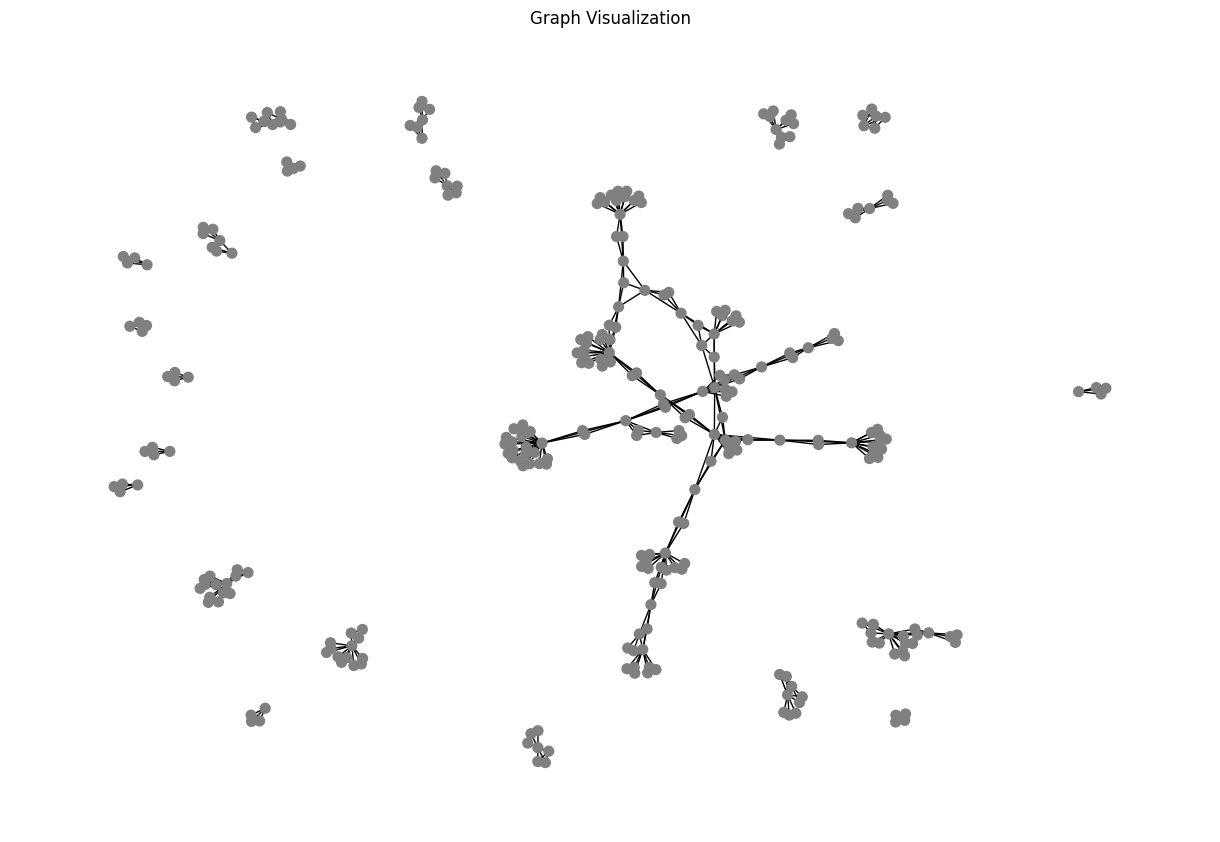

In [254]:
visualize_graph(G, node_colors)